Code from "Next Word Prediction using LSTM with TensorFlow" by Düzgün İlaslan at https://medium.com/@ilaslanduzgun/next-word-prediction-using-lstm-with-tensorflow-e2a8f63b613c.  

Modified to use Encoder-Decoder system a.k.a. Sequence-to-Sequence text generation

In [2]:
import numpy as np 
from numpy import array, argmax, array_equal
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from random import randint
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

In [2]:
#read dataset
with open('sherlock-holm.es_stories_plain-text_advs.txt', 'r', encoding='utf-8') as file:
    text = file.read()

In [3]:
#Tokenizer process
tokenizer = Tokenizer()
#fit
tokenizer.fit_on_texts([text])
#assign length of word index
total_words = len(tokenizer.word_index) + 1

In [4]:
list(tokenizer.word_index)[0:5]

['the', 'and', 'i', 'to', 'of']

In [5]:
#declare ngrams
# Uses the inner for loop to build a 2-gram, 3-gram, 4-gram, etc, till we get to an n-gram that is as long as the sentence.
input_sequences = []
#split the sentence from '\n'
for line in text.split('\n'):
    #get tokens
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [6]:
# total number of n-grams from this dataset
len(input_sequences)

96314

In [7]:
# example showing how the n-grams are built
for i in range(0,4):
    print(input_sequences[i])

[1, 1561]
[1, 1561, 5]
[1, 1561, 5, 129]
[1, 1561, 5, 129, 34]


In [8]:
# check to see the words in the tokens
sentence_token = input_sequences[3] # [1, 1561, 5, 129, 34]
sentence = []
for token in sentence_token: #retrieve the word at each token number
    sentence.append(list((tokenizer.word_index).keys())[list((tokenizer.word_index).values()).index(token)])
print(sentence)

['the', 'adventures', 'of', 'sherlock', 'holmes']


In [9]:
#maximum sentence length
max_sequence_len = max([len(seq) for seq in input_sequences])
# input sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
# we've created a numpy array that contains all the n-grams, one per row. ...
# Also, we've made each row equal to the size of the maximum sentence length...
# and padded all sentences shorter than that with zeros.  
# Note that the the padding and tokenizing is done the same was as the NLP Spam Filter lab in DSS 420, Module 3

In [10]:
# sample the sequences:
input_sequences[0:15,-5:-1]

array([[   0,    0,    0,    1],
       [   0,    0,    1, 1561],
       [   0,    1, 1561,    5],
       [   1, 1561,    5,  129],
       [   0,    0,    0,  647],
       [   0,    0,  647, 4498],
       [   0,    0,    0,  226],
       [   0,    0,  226,    5],
       [   0,    0,    0,    6],
       [   0,    0,    6,  827],
       [   0,    6,  827,    7],
       [   0,    0,    0,    1],
       [   0,    0,    1,  234],
       [   0,    1,  234,  462],
       [   0,    0,    0,    6]])

Now, our input sequences will be everything except the last word.  We will make the last word (i.e. next word in the sequence) equal the target word.  This is similar to the Sunspot prediction lab in DSS 320, where we put the first 12 months in the sequence as the input to the LSTM, and then made the 13th month the target that we try to predict.  

In [11]:
X = input_sequences[:, :-1]
y = input_sequences[:, -1]

print(X[2])
print(y[2]) # that is, given token 1, try to predict token 1561 (and by correspondence the word that it represents)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    1 1561    5]
129


Now the predicted value represents a class label, not the integer.  For example, if the predicted value of y[0] is 1561, "1561" here represents the token 1561, and not the number.  We want to train the classifier on the tokens as class labels, not as integers.  Otherwise, we risk converting the model into an estimator, which would give us incorrect results. 

For example, if the model predicted the output to be "1562" because the integer "1562" is close in value to the integer "1561", that does not apply to our case, because the word represented by token "1562" could be totally different than the word represented by "1561".  

So let's convert this to a catergorical variable and encode it with one-hot state encoding

In [12]:
y = np.array(tf.keras.utils.to_categorical(y, num_classes=total_words))

In [13]:
print("Shape of y after converting to categorical is ", y.shape)

Shape of y after converting to categorical is  (96314, 8200)


In [14]:
print(y.shape)

(96314, 8200)


In [15]:
# split to train/test for validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
    y, test_size=0.3, random_state=1)

In [16]:
print(X_train.shape)
print(X_test.shape)

(67419, 17)
(28895, 17)


In [17]:
total_words

8200

In [18]:
#create model
model = Sequential()
# Embedding layer takes tokenized inputs where:
# - input_length: each (padded) tokenized sentence is 8200 in length (see size above)
# - input dim: vocabulary size = total_words
# - output_dim: embedded vector size for each word = 100
model.add(Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len-1))
# 150 LSTM layers
num_layers = 50
#model.add(LSTM(num_layers))
model.add((LSTM(num_layers,dropout=0.1)))
#model.add(Dense(num_layers,activation='relu'))
# You want one output for each word (prediction for each word), ...
# ... so size of output of the final Dense layer is "total_words"=vocabulary size
model.add(Dense(total_words, activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 100)           820000    
                                                                 
 lstm (LSTM)                 (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 8200)              418200    
                                                                 
Total params: 1,268,400
Trainable params: 1,268,400
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
#compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#fit the model
model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
2107/2107 [==============================] - 43s 19ms/step - loss: 6.4893 - accuracy: 0.0565 - val_loss: 6.2889 - val_accuracy: 0.0672
Epoch 2/50
2107/2107 [==============================] - 41s 19ms/step - loss: 5.9313 - accuracy: 0.0853 - val_loss: 5.9904 - val_accuracy: 0.1025
Epoch 3/50
2107/2107 [==============================] - 36s 17ms/step - loss: 5.5722 - accuracy: 0.1145 - val_loss: 5.8976 - val_accuracy: 0.1151
Epoch 4/50
2107/2107 [==============================] - 36s 17ms/step - loss: 5.3273 - accuracy: 0.1330 - val_loss: 5.8654 - val_accuracy: 0.1208
Epoch 5/50
2107/2107 [==============================] - 44s 21ms/step - loss: 5.1204 - accuracy: 0.1448 - val_loss: 5.8708 - val_accuracy: 0.1262
Epoch 6/50
2107/2107 [==============================] - 39s 18ms/step - loss: 4.9396 - accuracy: 0.1598 - val_loss: 5.9048 - val_accuracy: 0.1299
Epoch 7/50
2107/2107 [==============================] - 44s 21ms/step - loss: 4.7801 - accuracy: 0.1707 - val_loss: 5.9503 -

<AxesSubplot:>

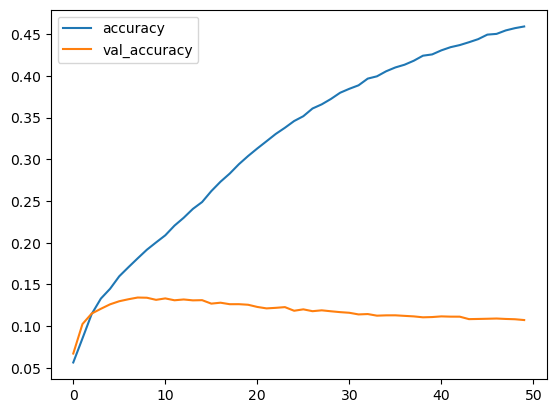

In [20]:
losses = pd.DataFrame(model.history.history)
losses.loc[:,['accuracy','val_accuracy']].plot()

In [21]:
plt.savefig("Model performance with " + str(num_layers) + " LSTM Layers - Bidirectionl.png")
losses.to_csv("Model performance with " + str(num_layers) + " LSTM Layers - Bidirectionl.csv")

<Figure size 640x480 with 0 Axes>

### Inference (testing your model)

In [31]:
#determine a text
seed_text = "Elementary my dear"

#convert to token
token_list = tokenizer.texts_to_sequences([seed_text])[0]
#pad sequences
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
#model prediction
predicted = np.argmax(model.predict(token_list), axis=-1)


1/1 [==============================] - 0s 17ms/step


In [32]:
predicted_word = list((tokenizer.word_index).keys())[list((tokenizer.word_index).values()).index(predicted)]
print("Next predicted word is: ", predicted_word)
print("So whole next sentence is: ", seed_text, predicted_word)

Next predicted word is:  watson
So whole next sentence is:  Elementary my dear watson


In [34]:
# Now what if you wanted a whole sentence:

#determine a text
seed_text = "Watson the game is"
# predict word number
next_words = 5

for _ in range(next_words):
    #convert to token
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    #path sequences
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    #model prediction
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    # get predict words
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
    
seed_text

1/1 [==============================] - 0s 13ms/step


'Watson the game is stirring three bills upon a'

**What did we learn?**
LSTM's do a pretty bad job at next word prediction.  While the training accuracy after 50 epochs was greater than 40%, the validation accuracy was only about 10%.  

More advanced methods such as *Encoder-Decoder* and *Attention* models should improve performance.  